In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
hierarchy = pd.read_csv('https://github.com/Sputniza/data_challenges/blob/master/company_hierarchy.csv')

In [3]:
employee = pd.read_csv('https://github.com/Sputniza/data_challenges/blob/master/employee.csv')

In [4]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [5]:
employee.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [6]:
employee_dept = hierarchy.loc[:,("employee_id", "dept")] 

In [7]:
# amend dept to employee table for further analysis
full_data = pd.merge(employee, employee_dept, on = "employee_id")

In [8]:
full_data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,138719,0,273000.0,Master,M,2,engineering
1,3192,0,301000.0,Bachelor,F,1,sales
2,114657,0,261000.0,Master,F,2,sales
3,29039,0,86000.0,High_School,F,4,HR
4,118607,0,126000.0,Bachelor,F,3,sales


In [ ]:
full_data.sex.mean()

In [10]:
print hierarchy.describe()
print
print hierarchy.head(5)
print
print

         employee_id        boss_id
count   10000.000000    9999.000000
mean   100001.855800  103299.980498
std     57500.488641   57508.798817
min        40.000000      79.000000
25%     50574.500000   55883.000000
50%     99244.500000  102712.000000
75%    149748.500000  152288.000000
max    199956.000000  199950.000000

   employee_id   boss_id   dept
0        46456  175361.0  sales
1       104708   29733.0     HR
2       120853   41991.0  sales
3       142630  171266.0     HR
4        72711  198240.0  sales




In [11]:
hierarchy["receive_reports"] = hierarchy.employee_id.isin(hierarchy.boss_id)

In [12]:
hierarchy.head()

,employee_id,boss_id,dept,receive_reports
0,46456,175361.0,sales,False
1,104708,29733.0,HR,False
2,120853,41991.0,sales,False
3,142630,171266.0,HR,True
4,72711,198240.0,sales,False


In [13]:
hierarchy["people_managed"] = 0

In [14]:
data = hierarchy.copy()
level_0 = data.loc[data["receive_reports"] == False, "employee_id"].tolist()

# fill missing value 
data["boss_id"].fillna(0, inplace = True)
data["boss_id"] = data["boss_id"].astype(int)
# important to reference item not Series
data.loc[data.employee_id == 72711, "boss_id"].item()

198240

In [15]:
direct_reports = data.boss_id.tolist()

levels = []
seen = []
def sum_reports(current_level):
    
    levels.append(current_level)
    # pass current level of employees as list
    if len(current_level) <= 1:
        return
    else:
        next_level = []
        #find boss for every employee at current level and add to next level + add 1 to report of this boss
        for emp in current_level:
            tmp_boss = data.loc[data.employee_id == emp, "boss_id"].item()
            seen.append(tmp_boss)
            
            #print 'employee: ',emp, '--> boss: ', tmp_boss
            if direct_reports.count(tmp_boss) == seen.count(tmp_boss) and tmp_boss != 0:    
                next_level.append(tmp_boss)
                
            sofar = data.loc[data.employee_id == emp, "people_managed"].item()
            # add reports, plus 1 and the reports sofar of the current emp    
            data.loc[(data.employee_id == tmp_boss),"people_managed"] += (sofar+1)
            
        sum_reports(next_level)

sum_reports(level_0)

In [16]:
# add level-column as requested in the challenge
count = 0
level_names = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
for level in levels:
    for person in level:
        full_data.loc[full_data["employee_id"] == person, "level"] = level_names[count]
    count += 1

In [17]:
full_data.level.value_counts()

IC     9001
MM      800
D       159
VP       35
E         4
CEO       1
Name: level, dtype: int64

In [18]:
# check the bosses for every dept reporting to the CEO
data.loc[data.boss_id == 61554]

,employee_id,boss_id,dept,receive_reports,people_managed
1009,110464,61554,marketing,True,2009
1310,11277,61554,sales,True,3598
2778,51535,61554,engineering,True,2695
9640,93708,61554,HR,True,1693


In [19]:
# check CEO
data.loc[data.employee_id == 61554, :]

,employee_id,boss_id,dept,receive_reports,people_managed
2427,61554,0,CEO,True,9999


In [20]:
employee_subs = data.loc[:,("employee_id", "people_managed")]

In [21]:
full_data = pd.merge(full_data, employee_subs, on = "employee_id")

In [60]:
full_data.to_csv("enriched_diversity.csv", index=False)

In [22]:
full_data.salary = full_data.salary.astype(int)

In [23]:
# average salary/ signing bonus/ exp/ reports of women/men
full_data.groupby('sex').mean()

,employee_id,signing_bonus,salary,yrs_experience,people_managed
sex,,,,,
F,100164.731536,0.271553,171314.518394,3.931199,2.985959
M,99911.779624,0.317907,198954.340736,3.844230,5.920329


building some intuition
women on average do have as many subordinates, than men but 27.000 less in salary on average

some quick plotting

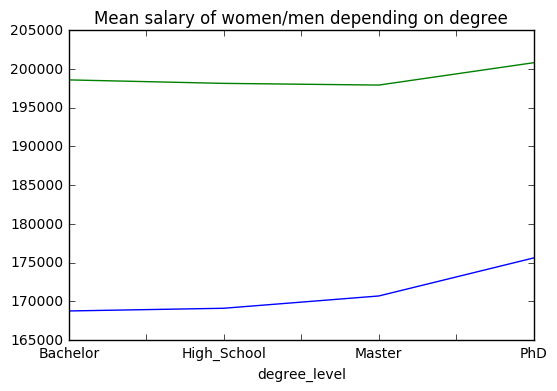

In [24]:
# compute salary per degree level, women vs men
employee[employee["sex"] == 'F'].groupby('degree_level').salary.mean().plot(kind = 'line', title = 'Mean salary of women/men depending on degree')
employee[employee["sex"] == 'M'].groupby('degree_level').salary.mean().plot(kind = 'line')

In [26]:
# preparing the data as X to build a model - translate categorical data in numerical data
X = full_data.copy()

In [27]:
full_data.to_csv("diversity_data.csv", index=False)

In [28]:
# choose numeric representation for gender
X.loc[X["sex"] == "M", "sex"] = 0
X.loc[X["sex"] == "F", "sex"] = 1

In [29]:
X.degree_level.value_counts()

PhD            2822
Master         2786
Bachelor       2735
High_School    1657
Name: degree_level, dtype: int64

In [30]:
# choose numeric representation for degree_level
X.loc[X["degree_level"] == "PhD", "degree_level"] = 3
X.loc[X["degree_level"] == "Master", "degree_level"] = 2
X.loc[X["degree_level"] == "Bachelor", "degree_level"] = 1
X.loc[X["degree_level"] == "High_School", "degree_level"] = 0
X.degree_level = X.degree_level.astype(int)

In [31]:
X.dept.value_counts()

sales          3599
engineering    2696
marketing      2010
HR             1694
CEO               1
Name: dept, dtype: int64

In [32]:
# choose numeric representation for dept
X.loc[X["dept"] == "CEO", "dept"] = 4
X.loc[X["dept"] == "HR", "dept"] = 3
X.loc[X["dept"] == "marketing", "dept"] = 2
X.loc[X["dept"] == "engineering", "dept"] = 1
X.loc[X["dept"] == "sales", "dept"] = 0
X.dept = X.dept.astype(int)

In [33]:
# choose numeric representation for level
X.loc[X["level"] == "CEO", "level"] = 5
X.loc[X["level"] == "E", "level"] = 4
X.loc[X["level"] == "VP", "level"] = 3
X.loc[X["level"] == "D", "level"] = 2
X.loc[X["level"] == "MM", "level"] = 1
X.loc[X["level"] == "IC", "level"] = 0
X.level = X.level.astype(int)

In [34]:
full_data.loc[X.level == 4]

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,dept,level,people_managed
8184,93708,1,500000,PhD,F,28,HR,E,1693
8235,51535,1,650000,PhD,M,33,engineering,E,2695
9119,11277,1,550000,Master,M,22,sales,E,3598
9410,110464,1,550000,Master,M,21,marketing,E,2009


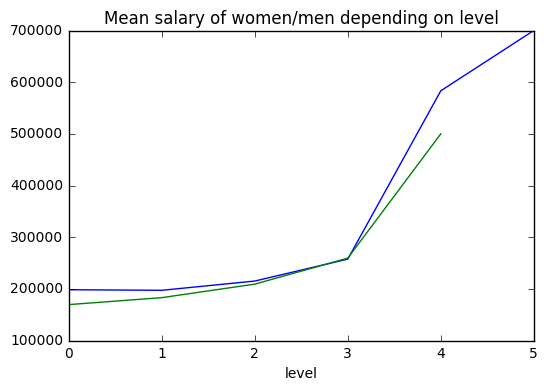

In [35]:
# compute salary per management level, women vs men
X[X["sex"] == 0].groupby('level').salary.mean().plot(kind = 'line', title = 'Mean salary of women/men depending on level')
X[X["sex"] == 1].groupby('level').salary.mean().plot(kind = 'line')

In [36]:
y = X.pop("salary")

In [59]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1)

# Random tree

In [39]:
%%timeit
# build quick model for benchmark
RF = RandomForestRegressor(n_estimators = 200, oob_score = True, n_jobs = 1, random_state=42)
RF.fit(X_train,y_train)

1 loop, best of 3: 9.06 s per loop


In [40]:
%%timeit
# build quick model for benchmark
RF = RandomForestRegressor(n_estimators = 200, oob_score = True, n_jobs = -1, random_state=42)
RF.fit(X_train,y_train)

1 loop, best of 3: 4.87 s per loop


# n_estimator

In [41]:
# find best n_estimator
scores = []
oob_scores =[]
n_range = range(100,2000,100)

for trees in n_range:
    RF = RandomForestRegressor(n_estimators = trees, oob_score = True, n_jobs= -1, random_state = 42, max_features = 'auto')
    RF.fit(X_train,y_train)
    #print model.oob_prediction_
    print trees, 'trees'
    #roc = roc_auc_score(y_train, model.oob_prediction_)
    r2 = RF.score(X_test,y_test)
    print 'R2-score: ', r2
    print 'Oob_score: ', RF.oob_score_
    scores.append(r2)
    oob_scores.append(RF.oob_score_)
    print ''

100 trees
R2-score:  0.23352146266
Oob_score:  0.226357835728

200 trees
R2-score:  0.238552545612
Oob_score:  0.236406782948

300 trees
R2-score:  0.23875845504
Oob_score:  0.239045664914

400 trees
R2-score:  0.239248791418
Oob_score:  0.240295799819

500 trees
R2-score:  0.239106897478
Oob_score:  0.24045981792

600 trees
R2-score:  0.2392848994
Oob_score:  0.24027547479

700 trees
R2-score:  0.240104651476
Oob_score:  0.24034567316

800 trees
R2-score:  0.240492543845
Oob_score:  0.240182590851

900 trees
R2-score:  0.240969972624
Oob_score:  0.240250583221

1000 trees
R2-score:  0.240515315384
Oob_score:  0.240659744296

1100 trees
R2-score:  0.240426532032
Oob_score:  0.24049916182

1200 trees
R2-score:  0.240059999363
Oob_score:  0.240439233822

1300 trees
R2-score:  0.239796612685
Oob_score:  0.240699937531

1400 trees
R2-score:  0.239755586474
Oob_score:  0.240689761806

1500 trees
R2-score:  0.239733257939
Oob_score:  0.240758830063

1600 trees
R2-score:  0.239866927727
Oob_s

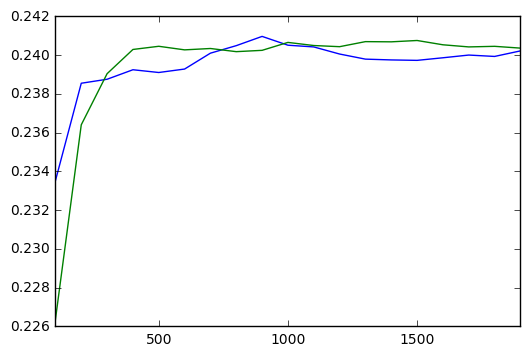

In [42]:
pd.Series(scores, n_range).plot()
pd.Series(oob_scores, n_range).plot()    

# min_samples_leaf

1 min_samples
R2-score:  0.2392848994
Oob_score:  0.24027547479

11 min_samples
R2-score:  0.315652737085
Oob_score:  0.315687392942

21 min_samples
R2-score:  0.325161069057
Oob_score:  0.324502144946

31 min_samples
R2-score:  0.328699672587
Oob_score:  0.328320246009

41 min_samples
R2-score:  0.331533513952
Oob_score:  0.329948856767

51 min_samples
R2-score:  0.333431693443
Oob_score:  0.330610684634

61 min_samples
R2-score:  0.334093019368
Oob_score:  0.331310430407

71 min_samples
R2-score:  0.334374190884
Oob_score:  0.331757446804

81 min_samples
R2-score:  0.333421389819
Oob_score:  0.331703382178

91 min_samples
R2-score:  0.332798670894
Oob_score:  0.331472373343

101 min_samples
R2-score:  0.332497429482
Oob_score:  0.33182504114

111 min_samples
R2-score:  0.332180853628
Oob_score:  0.332098510813

121 min_samples
R2-score:  0.331863336003
Oob_score:  0.332501326529

131 min_samples
R2-score:  0.331724899246
Oob_score:  0.332901077163

141 min_samples
R2-score:  0.331702

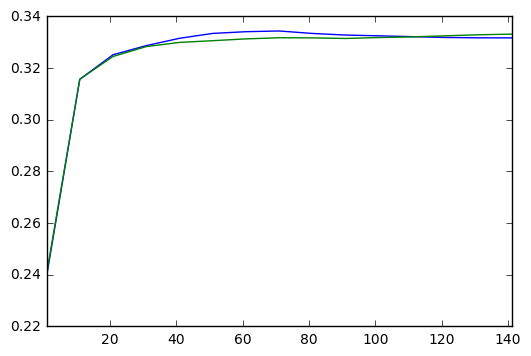

In [43]:
# find best min_samples_leaf
scores = []
oob_scores = []
min_samples_leaf_options = range(1,150,10)

for leaf_size in min_samples_leaf_options:
    RF = RandomForestRegressor(n_estimators = 600,
                                  oob_score = True, 
                                  n_jobs= -1, 
                                  random_state = 42, 
                                  max_features = 'auto',
                                  min_samples_leaf = leaf_size, )
    RF.fit(X_train,y_train)
    print leaf_size, 'min_samples'
    r2 = RF.score(X_test,y_test)
    print 'R2-score: ', r2
    print 'Oob_score: ', RF.oob_score_
    scores.append(r2)
    oob_scores.append(RF.oob_score_)
    print ''
    
pd.Series(scores, min_samples_leaf_options).plot()
pd.Series(oob_scores, min_samples_leaf_options).plot()    

# max features

In [44]:
# find max_features
scores = []
oob_scores = []
max_features_options = ["auto",None,"sqrt", "log2", 0.9, 0.2]

for max_feature in max_features_options:
    RF = RandomForestRegressor(n_estimators = 600,
                                  oob_score = True, 
                                  n_jobs= -1, 
                                  random_state = 42, 
                                  max_features = max_feature,
                                  min_samples_leaf = 70, )
    RF.fit(X_train,y_train)
    print 'max_feature: ', max_feature
    r2 = RF.score(X_test,y_test)
    print 'R2-score: ', r2
    print 'Oob_score: ', RF.oob_score_
    oob_scores.append(RF.oob_score_)
    scores.append(r2)
    print ''


max_feature:  auto
R2-score:  0.334350626691
Oob_score:  0.33174053575

max_feature:  None
R2-score:  0.334350626691
Oob_score:  0.33174053575

max_feature:  sqrt
R2-score:  0.321072338177
Oob_score:  0.310765069851

max_feature:  log2
R2-score:  0.335817201868
Oob_score:  0.328449316971

max_feature:  0.9
R2-score:  0.335392195888
Oob_score:  0.332674894449

max_feature:  0.2
R2-score:  0.274476989497
Oob_score:  0.263921976238



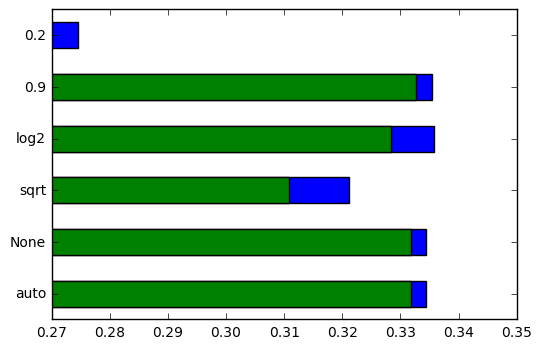

In [45]:
pd.Series(scores, max_features_options).plot(kind ="barh", xlim = (.27,.35))
pd.Series(oob_scores, max_features_options).plot(kind ="barh", color = "green", xlim = (.27,.35))    

In [46]:
# model

RF = RandomForestRegressor(n_estimators = 600,
                                oob_score = True, 
                                n_jobs= -1, 
                                random_state = 42, 
                                max_features = 0.9,
                                min_samples_leaf = 70, )
RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=70, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [47]:
RF.feature_importances_

array([ 0.04279716,  0.00361574,  0.00800554,  0.00786397,  0.01187758,
        0.91961073,  0.00132593,  0.00490335])

In [48]:
dept = X.pop('dept')

As the dept has by far the highest feature importance - try the model once without (as CEO is a whole dept and also 

In [49]:
RF = RandomForestRegressor(n_estimators = 600,
                                oob_score = True, 
                                n_jobs= -1, 
                                random_state = 42, 
                                max_features = 0.9,
                                min_samples_leaf = 70, )
RF.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=70, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [50]:
RF.feature_importances_

array([ 0.33753436,  0.1528358 ,  0.05483649,  0.31272529,  0.09696226,
        0.00236026,  0.04274554])

# insights & conclusions 

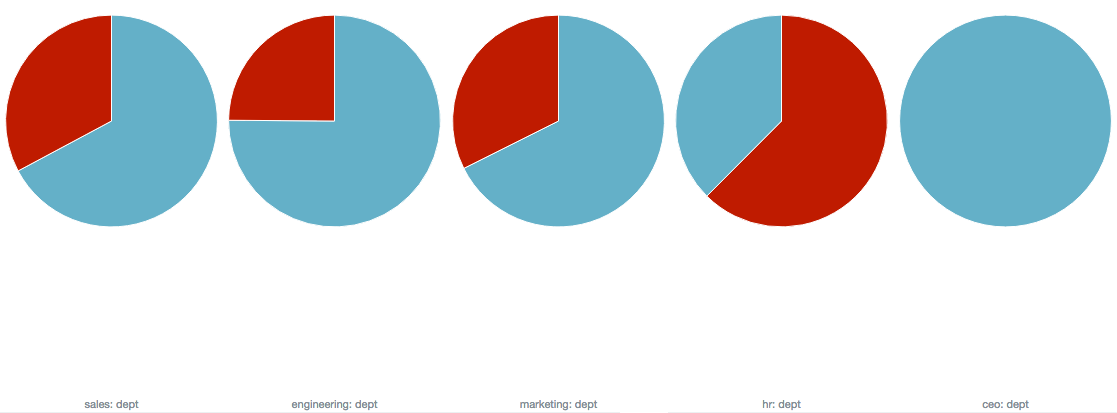

In [51]:
from IPython.core.display import Image
Image(filename = ("/COGNAC/LERNEN/DSE/Take_Home_Challenges/Diversity_in_the_workplace/ratio_dept.png"))

Women are vastly underrepresented in all departments except HR.

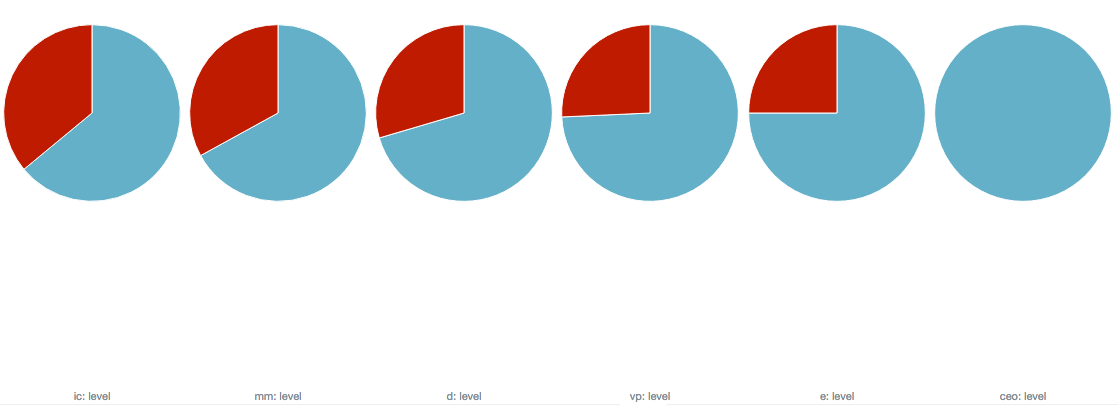

In [52]:
from IPython.core.display import Image
Image(filename = ("/COGNAC/LERNEN/DSE/Take_Home_Challenges/Diversity_in_the_workplace/ratio_level.png"))

Considering the career path (by levels of management) the share of women is constantly decreasing.

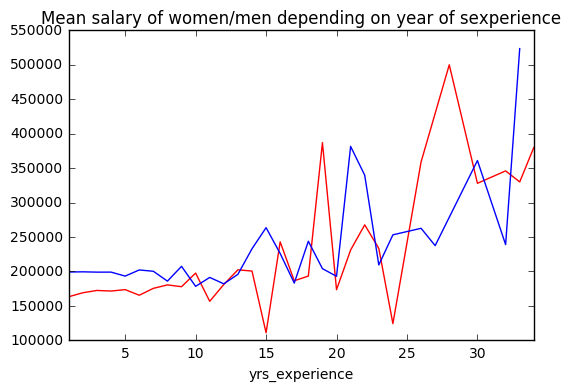

In [56]:
# compute mean salary per yoe, women vs men
full_data[full_data["sex"] == 'F'].groupby('yrs_experience').salary.mean().plot(kind = 'line', color = 'Red', title = 'Mean salary of women/men depending on year of sexperience', label = 'women')
full_data[full_data["sex"] == 'M'].groupby('yrs_experience').salary.mean().plot(kind = 'line', color = 'Blue', label = 'men')

The pay gap is most stable and significant in the first 10 years ... That is also, where most of the data is available. For more reliable analysis of people with many years of working experiences and also in high positions it would be important to have more datapoints in this segment.

Describe the main factors impacting employee salaries. Do you think the company has
been treating its employees fairly? Do you see any bias? What are the next steps you
would suggest to the Head of HR?

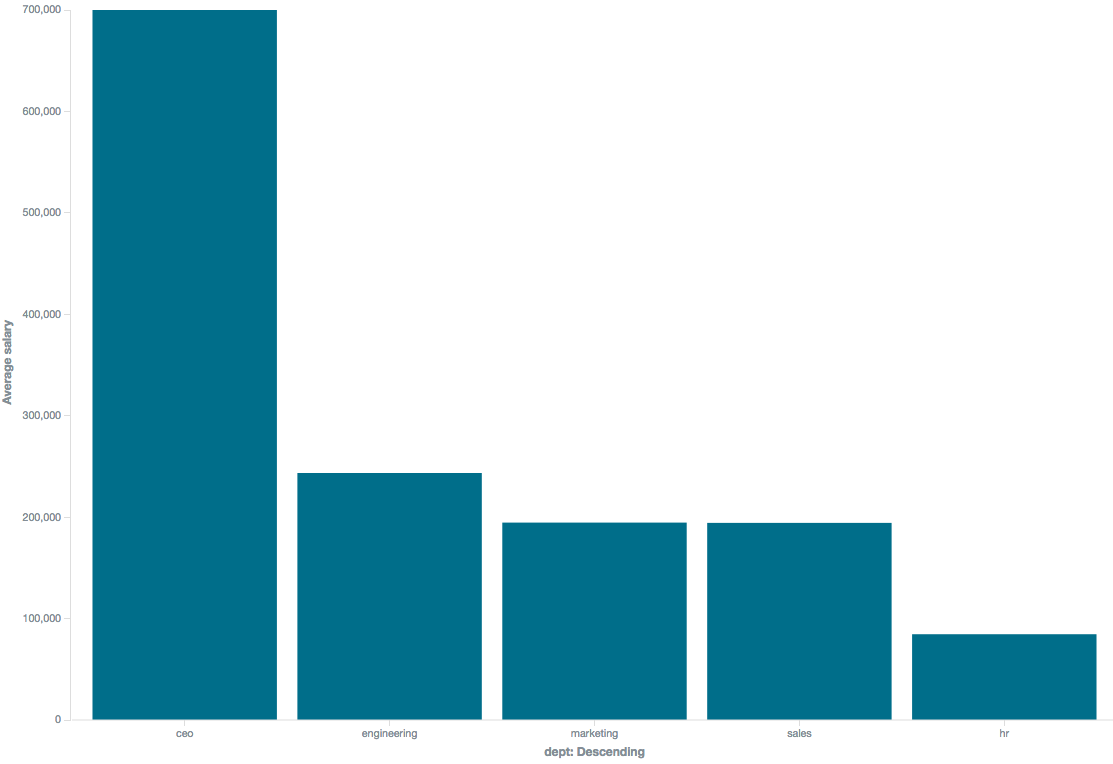

In [57]:
from IPython.core.display import Image
Image(filename = ("/COGNAC/LERNEN/DSE/Take_Home_Challenges/Diversity_in_the_workplace/dept_salary.png"))

My model shows that department is most importantly impacting the salary. AS this seems skewed by the CEO being a single department and earning by far the most money ... I did another model without department. Now sex is the most influential feature on predicting salary.

For further analysis it would be important to have more data on the development of employees in the company, as of promtions, working periods, also hiring data (as people are hired at different points in their carreers) - This would make it possible to differentiate between bias in hiring and bias in supporting inside the company ..